In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

In [2]:
df = pd.read_csv('./base_limpa/base_sim_dofet_limpa_remocao.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243173 entries, 0 to 243172
Data columns (total 34 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   data_obito             243173 non-null  object 
 1   ano_obito              243173 non-null  int64  
 2   TIPOBITO               243173 non-null  int64  
 3   ocor_MUNNOMEX          243173 non-null  object 
 4   res_MUNNOMEX           243001 non-null  object 
 5   ocor_CAPITAL           243173 non-null  object 
 6   res_CAPITAL            243001 non-null  object 
 7   ocor_REGIAO            243173 non-null  object 
 8   res_REGIAO             243001 non-null  object 
 9   ocor_SIGLA_UF          243173 non-null  object 
 10  res_SIGLA_UF           243001 non-null  object 
 11  IDADEMAE               231233 non-null  float64
 12  idademae_faixa         243173 non-null  object 
 13  ESCMAE2010             224772 non-null  float64
 14  escolaridade_mae       243173 non-nu

O código calcula o risco relativo (RR) de óbito fetal entre diferentes categorias de recém-nascidos e gera um gráfico de erro para visualização. Ele faz isso comparando a frequência de óbitos em diferentes grupos definidos por idade gestacional (termo ou pré-termo) e adequação ao peso gestacional (AIG, PIG, GIG).

1. Cálculo do Risco Relativo (RR)
O risco relativo (RR) é uma medida de associação usada em epidemiologia para comparar a probabilidade de um evento entre dois grupos. No caso, queremos comparar o risco de óbito fetal entre diferentes grupos de recém-nascidos.

**RR = Número de óbitos no grupo exposto / Número de óbitos no grupo de referência**

Ou seja, se houver 100 óbitos em bebês pré-termo pequenos para idade gestacional (Pre_Termo_PIG) e 50 óbitos em bebês termo adequados para idade gestacional (Termo_AIG) o RR = 100/50 = 2, isso significa que o risco de óbito fetal no grupo Pre_Termo_PIG é duas vezes maior que no grupo Termo_AIG.

2. Intervalo de Confiança para o Risco Relativo
O código calcula um intervalo de confiança de 95% para o RR, utilizando a seguinte fórmula baseada no logaritmo do RR:

![ic.png](ic.png)

Onde:

* E é o número de óbitos no grupo exposto.
* R é o número de óbitos no grupo de referência.
* O fator 1.96 corresponde ao quantil da distribuição normal para um intervalo de confiança de 95%.

Isso ajuda a verificar se o RR é estatisticamente significativo (se o IC não inclui 1, a diferença entre os grupos é significativa).

In [5]:
def calculate_rr(df, region=None):
    if region:
        df = df[df['ocor_REGIAO'] == region].reset_index(drop=True)
    
    df['group'] = 'Termo_AIG'
    df.loc[(df['cat_periodo_nasc'] == 'termo') & (df['cat_peso_calc'] == 'PIG'), 'group'] = 'Termo_PIG'
    df.loc[(df['cat_periodo_nasc'] == 'pre_termo') & (df['cat_peso_calc'] == 'AIG'), 'group'] = 'Pre_Termo_AIG'
    df.loc[(df['cat_periodo_nasc'] == 'pre_termo') & (df['cat_peso_calc'] == 'PIG'), 'group'] = 'Pre_Termo_PIG'
    df.loc[(df['cat_periodo_nasc'] == 'termo') & (df['cat_peso_calc'] == 'GIG'), 'group'] = 'Termo_GIG'
    df.loc[(df['cat_periodo_nasc'] == 'pre_termo') & (df['cat_peso_calc'] == 'GIG'), 'group'] = 'Pre_Termo_GIG'
    
    total_deaths = df['group'].value_counts()
    rr_results = []
    comparisons = [
        ('Termo_AIG', 'Termo_PIG'),
        ('Termo_AIG', 'Pre_Termo_AIG'),
        ('Termo_AIG', 'Pre_Termo_PIG'),
        ('Termo_AIG', 'Termo_GIG'),
        ('Termo_AIG', 'Pre_Termo_GIG')
    ]
    
    for ref, exp in comparisons:
        if ref in total_deaths and exp in total_deaths:
            rr = total_deaths[exp] / total_deaths[ref]
            ci_lower = rr * np.exp(-1.96 * np.sqrt(1/total_deaths[exp] + 1/total_deaths[ref]))
            ci_upper = rr * np.exp(1.96 * np.sqrt(1/total_deaths[exp] + 1/total_deaths[ref]))
            rr_results.append({
                'Region': region if region else 'Brasil',
                'Comparison': f'{exp} vs {ref}',
                'RR': round(rr, 2),
                'CI Lower': round(ci_lower, 2),
                'CI Upper': round(ci_upper, 2)
            })
    
    return pd.DataFrame(rr_results)


In [6]:
df_brasil = calculate_rr(df)
# Exibindo os resultados
display(df_brasil)

,Region,Comparison,RR,CI Lower,CI Upper
0,Brasil,Termo_PIG vs Termo_AIG,0.97,0.96,0.99
1,Brasil,Pre_Termo_AIG vs Termo_AIG,2.10,2.07,2.13
2,Brasil,Pre_Termo_PIG vs Termo_AIG,2.69,2.66,2.73
3,Brasil,Termo_GIG vs Termo_AIG,0.27,0.27,0.28
4,Brasil,Pre_Termo_GIG vs Termo_AIG,1.07,1.06,1.09


In [7]:
df_regioes = pd.concat([calculate_rr(df, region) for region in df['ocor_REGIAO'].unique()])
display(df_regioes)

,Region,Comparison,RR,CI Lower,CI Upper
0,Norte,Termo_PIG vs Termo_AIG,0.86,0.82,0.90
1,Norte,Pre_Termo_AIG vs Termo_AIG,1.69,1.62,1.75
2,Norte,Pre_Termo_PIG vs Termo_AIG,1.74,1.68,1.81
3,Norte,Termo_GIG vs Termo_AIG,0.29,0.27,0.31
4,Norte,Pre_Termo_GIG vs Termo_AIG,1.10,1.05,1.14
0,Nordeste,Termo_PIG vs Termo_AIG,0.95,0.93,0.98
1,Nordeste,Pre_Termo_AIG vs Termo_AIG,1.71,1.67,1.75
2,Nordeste,Pre_Termo_PIG vs Termo_AIG,2.17,2.12,2.22
3,Nordeste,Termo_GIG vs Termo_AIG,0.30,0.29,0.32
4,Nordeste,Pre_Termo_GIG vs Termo_AIG,0.93,0.90,0.95


In [8]:
df_brasil.to_csv('resultado/rr_obitos_brasil.csv', index=False)
df_regioes.to_csv('resultado/rr_obitos_regiao.csv', index=False)

In [9]:
def graf_box_plot(df, nome_graf, label):
    # Configurações do gráfico
    fig, ax = plt.subplots(figsize=(10, 6))  # Tamanho do gráfico
    
    # Definindo as posições no eixo x
    x = np.arange(len(df['Comparison']))  # Posições para cada comparação
    width = 0.4  # Largura das barras
    
    # Definindo as cores das barras
    cores_barras = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']  
    cor_erro = 'black'  # Cor da bolinha do erro IC
    cor_linha_ic = 'gray'  # Cor da linha pontilhada do intervalo de confiança
    
    # Plotando as barras para o RR
    bars = ax.bar(x, df['RR'], width, color=cores_barras, alpha=0.7)
    
    # Adicionando os intervalos de confiança (linha pontilhada cinza)
    for i in range(len(df)):
        ax.plot([x[i], x[i]], [df['CI Lower'][i], df['CI Upper'][i]], 
                linestyle='--', color=cor_linha_ic)
    
    # Adicionando as bolinhas do intervalo de confiança
    ax.errorbar(x, df['RR'], 
                yerr=[df['RR'] - df['CI Lower'], df['CI Upper'] - df['RR']], 
                fmt='o', color=cor_erro, capsize=5)

    # Adicionando os valores de RR ao lado direito de cada barra
    for i, (rr, cor) in enumerate(zip(df['RR'], cores_barras)):
        ax.text(x[i] + width/2 + 0.05, rr, f'RR: {rr:.2f}', ha='left', va='center', 
                fontsize=10, color=cor)

    # Adicionando texto e labels
    dict_label = {'Brasil': 'Brazil', 'Norte': 'North', 'Nordeste': 'North East', 
                  'Sudeste': 'Southeast', 'Sul': 'South', 'Centro-Oeste': 'Midwest'}
    ax.set_xlabel("Newborn types", fontsize=12)
    ax.set_ylabel("Stillbirth Relative Risk (RR)", fontsize=12)
    ax.set_title(f"Relative Risk Stillbirth and Confidence Intervals by Newborn type {dict_label[label]}", fontsize=14)
    
    # Definindo os rótulos do eixo x
    ax.set_xticks(x)
    ax.set_xticklabels(df['Comparison'], rotation=45, ha="right", fontsize=10)
    
    # Adicionando a linha pontilhada cinza de referência em RR = 1
    ax.axhline(y=1, color='gray', linestyle='--', linewidth=1, label='No Effect (RR = 1)')
    
    # Criando legendas personalizadas
    legendas_rr = [mpatches.Patch(color=cor, label=comp) for cor, comp in zip(cores_barras, df['Comparison'])]
    legenda_ic = mlines.Line2D([], [], color='black', marker='o', linestyle='-', label='95% CI')  
    legenda_no_effect = mlines.Line2D([], [], color='gray', linestyle='--', label='No Effect (RR = 1)')

    # Criando a legenda com todos os elementos
    ax.legend(handles=legendas_rr + [legenda_no_effect, legenda_ic], fontsize=10)
    
    # Ajustando layout para não cortar labels
    fig.tight_layout()
    
    # Salvando a figura
    plt.savefig(nome_graf, dpi=300, bbox_inches='tight')
    
    # Mostrando o gráfico
    plt.show()


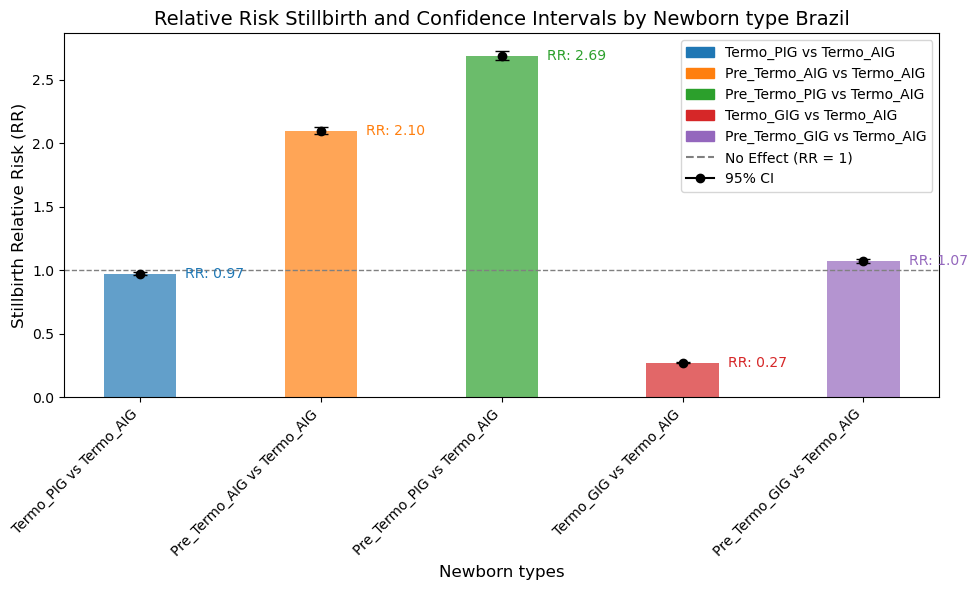

In [10]:
graf_box_plot(df=df_brasil, nome_graf='./graficos/box_plot_brasil_todos_os_anos_RR_sem_nasc.png', label='Brasil')

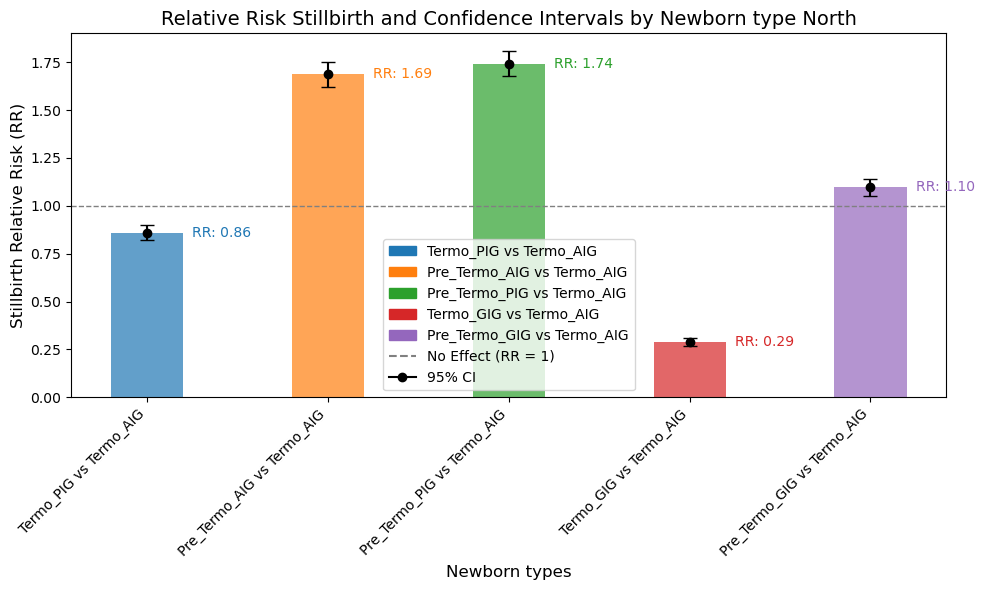

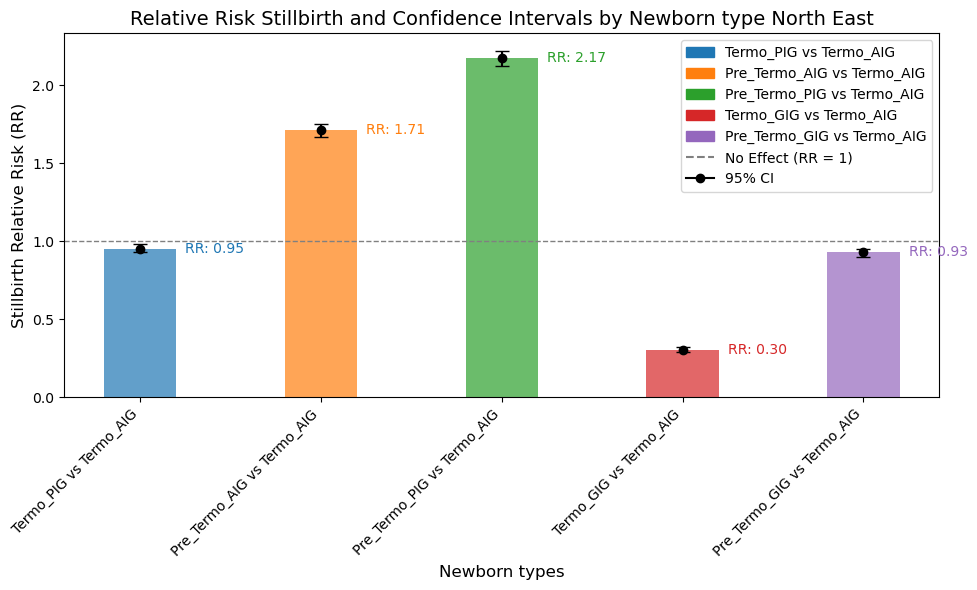

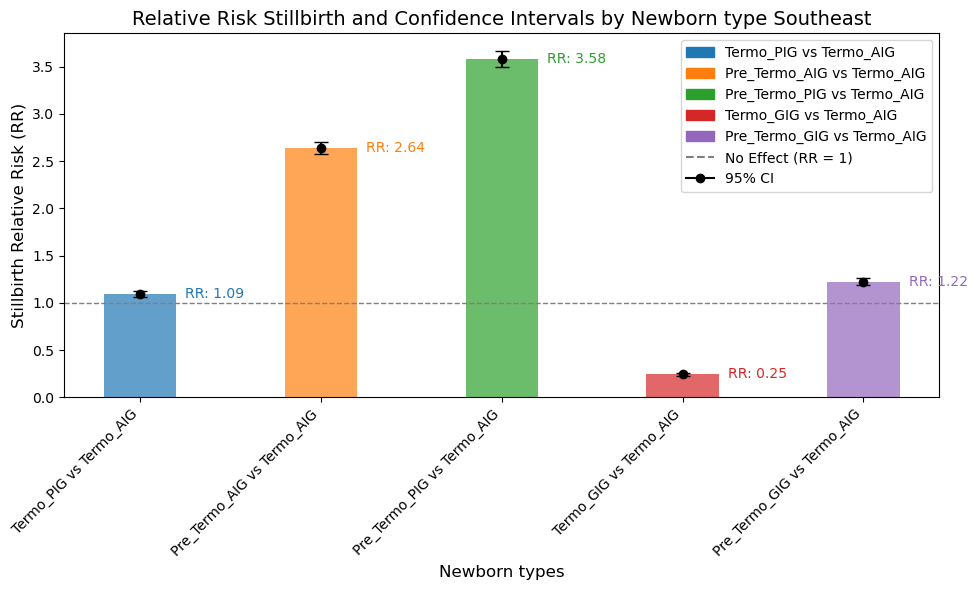

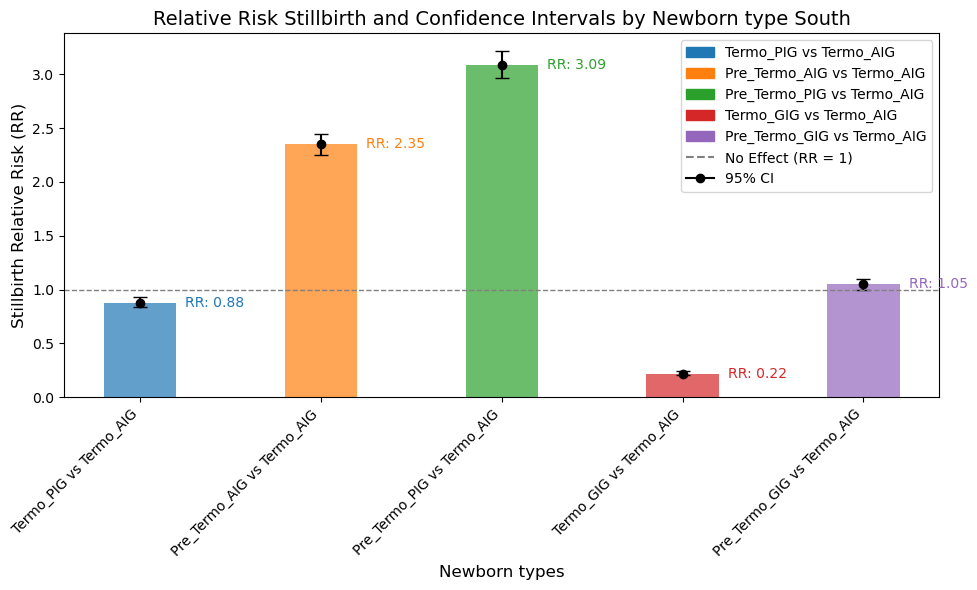

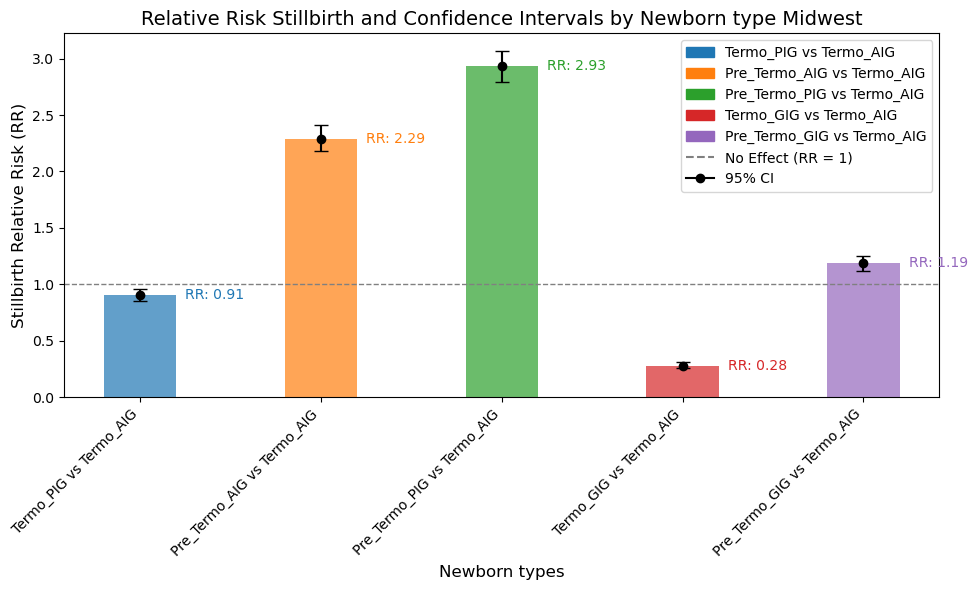

In [11]:
vet_reg = pd.unique(df_regioes['Region'])
for reg in vet_reg:
    df_graf_reg = df_regioes[df_regioes['Region']==reg].reset_index(drop=True)
    path = f'./graficos/box_plot_{reg}_todos_os_anos_RR_sem_nasc.png'
    graf_box_plot(df=df_graf_reg, nome_graf=path, label=reg)

# Removendo Zika e Covid

In [13]:
df = pd.read_csv('./base_limpa/base_sim_dofet_limpa_remocao.csv')
df = df[~df['ano_obito'].isin([2015, 2017, 2020, 2021, 2022])].reset_index(drop=True)

In [14]:
df_brasil_zika_covid = calculate_rr(df)
# Exibindo os resultados
display(df_brasil_zika_covid)

,Region,Comparison,RR,CI Lower,CI Upper
0,Brasil,Termo_PIG vs Termo_AIG,0.99,0.97,1.01
1,Brasil,Pre_Termo_AIG vs Termo_AIG,2.03,1.99,2.07
2,Brasil,Pre_Termo_PIG vs Termo_AIG,2.58,2.53,2.63
3,Brasil,Termo_GIG vs Termo_AIG,0.28,0.27,0.29
4,Brasil,Pre_Termo_GIG vs Termo_AIG,1.09,1.07,1.12


In [15]:
df_regioes_zika_covid = pd.concat([calculate_rr(df, region) for region in df['ocor_REGIAO'].unique()])
display(df_regioes_zika_covid)

,Region,Comparison,RR,CI Lower,CI Upper
0,Norte,Termo_PIG vs Termo_AIG,0.87,0.82,0.93
1,Norte,Pre_Termo_AIG vs Termo_AIG,1.67,1.58,1.76
2,Norte,Pre_Termo_PIG vs Termo_AIG,1.71,1.62,1.80
3,Norte,Termo_GIG vs Termo_AIG,0.29,0.27,0.32
4,Norte,Pre_Termo_GIG vs Termo_AIG,1.14,1.07,1.21
0,Nordeste,Termo_PIG vs Termo_AIG,0.98,0.94,1.01
1,Nordeste,Pre_Termo_AIG vs Termo_AIG,1.65,1.60,1.71
2,Nordeste,Pre_Termo_PIG vs Termo_AIG,2.06,2.00,2.13
3,Nordeste,Termo_GIG vs Termo_AIG,0.30,0.29,0.32
4,Nordeste,Pre_Termo_GIG vs Termo_AIG,0.95,0.92,0.99


In [16]:
df_brasil_zika_covid.to_csv('resultado/rr_obitos_brasil_zika_covid.csv', index=False)
df_regioes_zika_covid.to_csv('resultado/rr_obitos_regiao_zika_covid.csv', index=False)

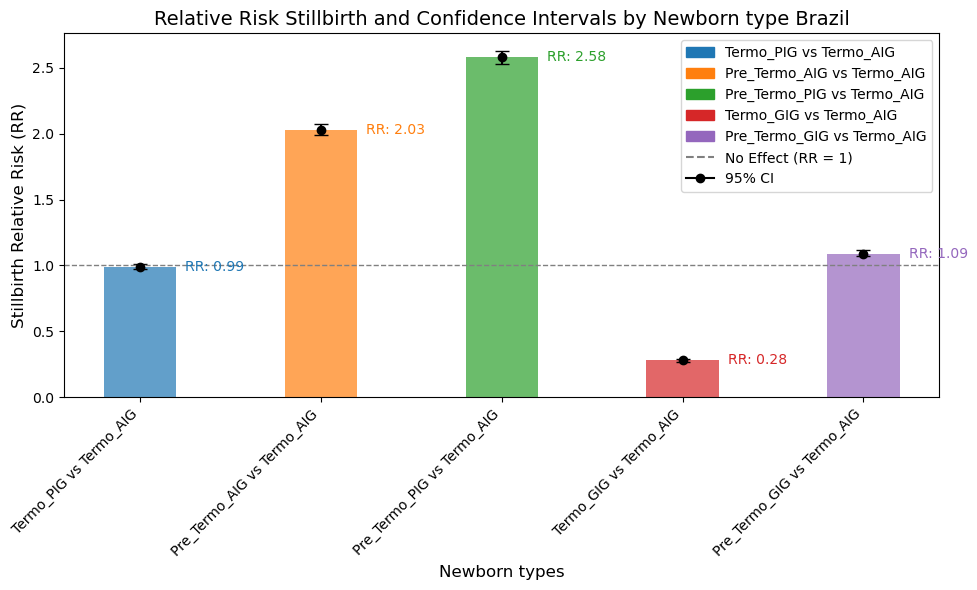

In [17]:
graf_box_plot(df=df_brasil_zika_covid, nome_graf='./graficos/box_plot_brasil_sem_zika_covid_os_anos_RR_sem_nasc.png', label='Brasil')

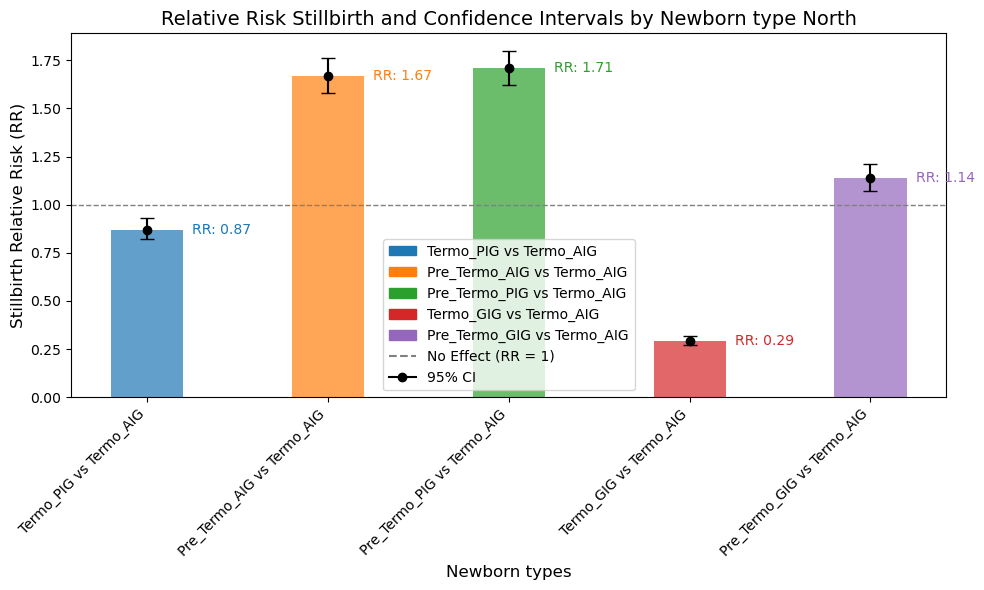

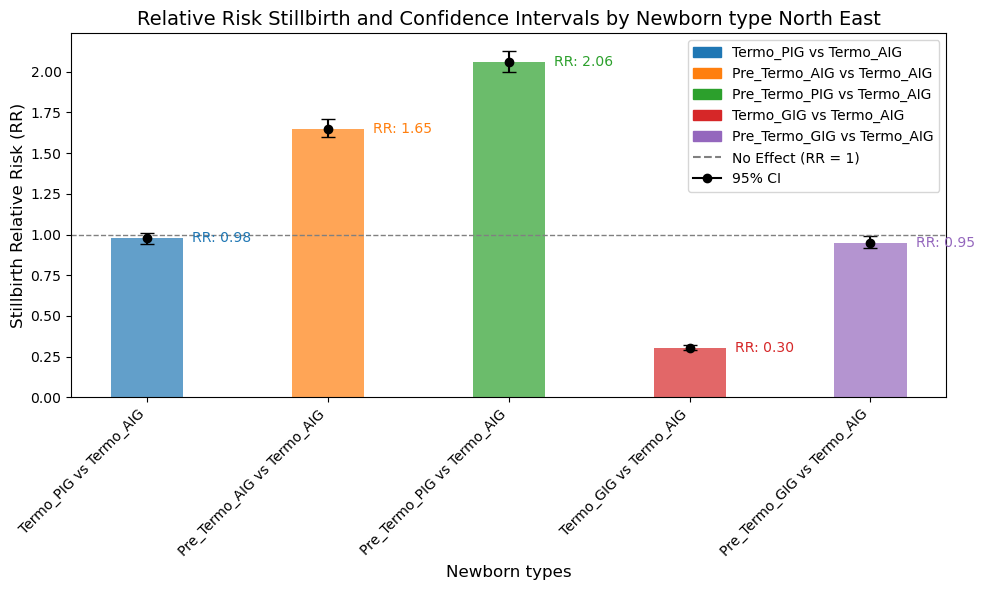

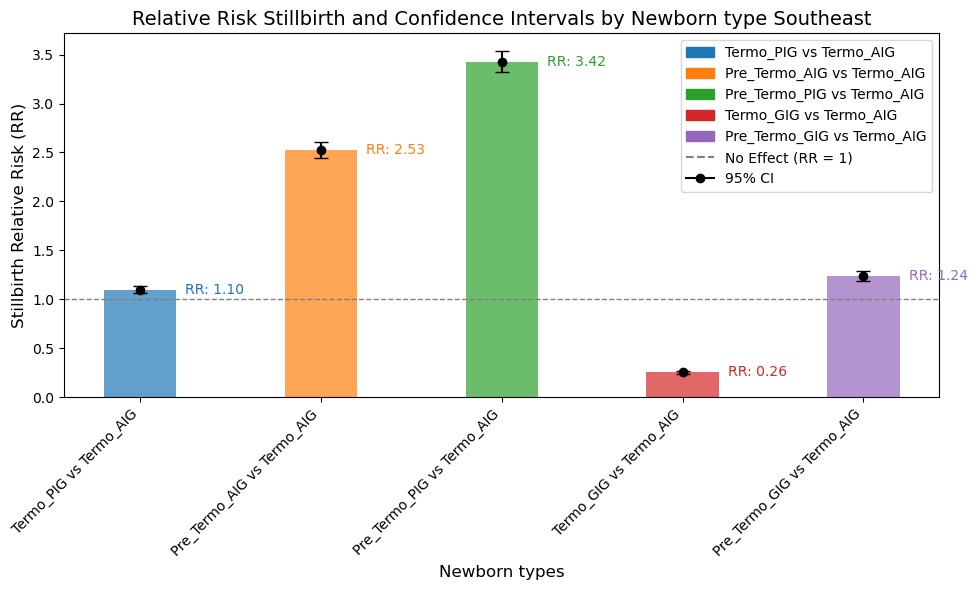

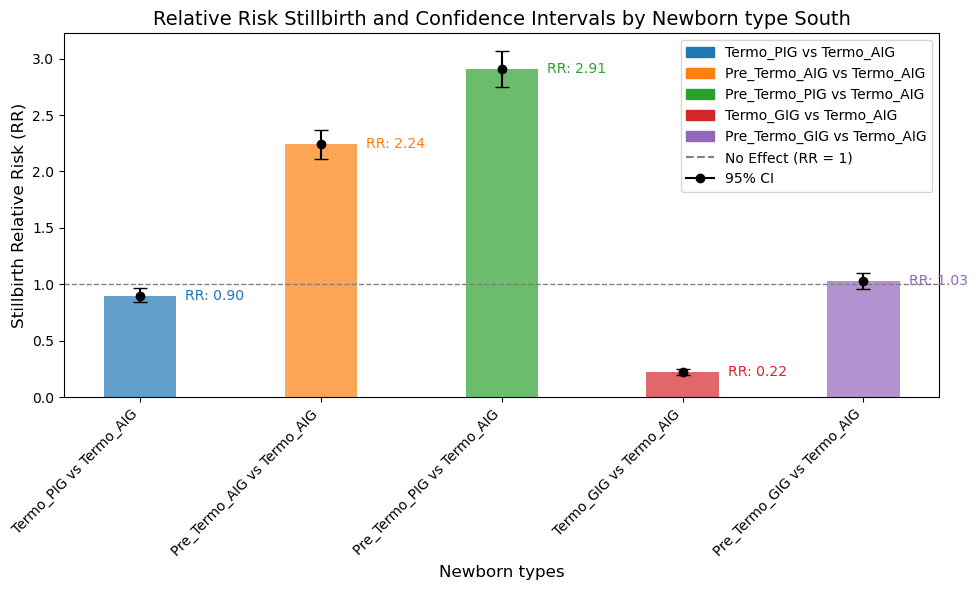

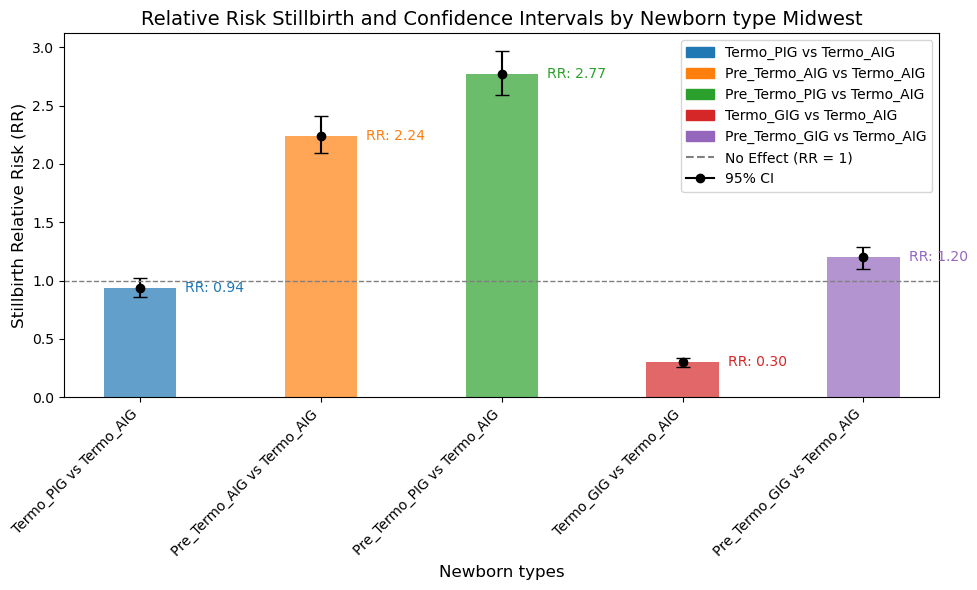

In [18]:
vet_reg = pd.unique(df_regioes_zika_covid['Region'])
for reg in vet_reg:
    df_graf_reg = df_regioes_zika_covid[df_regioes_zika_covid['Region']==reg].reset_index(drop=True)
    path = f'./graficos/box_plot_{reg}_sem_zika_covid_RR_sem_nasc.png'
    graf_box_plot(df=df_graf_reg, nome_graf=path, label=reg)